In [189]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from itertools import combinations, compress
import csv
import datetime
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm
import random
from numpyencoder import NumpyEncoder
from sklearn.neighbors.kde import KernelDensity
import math
import cvxpy as cp

In [155]:
phase_dirs = [
   'phased_ssc.hg38_phase1-1_del',
    'phased_ssc.hg38_phase1-2_del',
    'phased_ssc.hg38_phase1-3_del',
    'phased_ssc.hg38_phase1-4_del',
    'phased_ssc.hg38_phase1-5_del',
    'phased_ssc.hg38_phase1-7_del',
    'phased_ssc.hg38_phase2_B01_del',
    'phased_ssc.hg38_phase2_del',
    'phased_ssc.hg38_phase2_Replacements_del',
    'phased_ssc.hg38_phase3_1_B02_del',
    'phased_ssc.hg38_phase3_1_del',
    'phased_ssc.hg38_phase3_2_del',
    'phased_ssc.hg38_pilot_del',
]
dataset_name = 'ssc.hg38'

#phase_dirs = [
#    'phased_spark_wes1_array_quads_del',
#    'phased_spark_wes2_array_quads_del',
#    'phased_spark_wes3_array_quads_del',
#    'phased_spark_wgs1_b01_array_quads_del',
#    'phased_spark_wgs1_b02_array_quads_del',
#    'phased_spark_wgs2_array_quads_del',
#    'phased_spark_wgs3_array_quads_del',
#]
#dataset_name = 'spark'

#phase_dirs = [
#    'phased_ihart.ms2_quads_del',
#]
#dataset_name = 'ihart.ms2'

#phase_dirs = [
#    'phased_mssng_quads_del',
#]
#dataset_name = 'mssng'

#phase_dirs = [
#    'phased_ssc.hg38_phase1-1_del',
#    'phased_ssc.hg38_phase1-2_del',
#    'phased_ssc.hg38_phase1-3_del',
#    'phased_ssc.hg38_phase1-4_del',
#    'phased_ssc.hg38_phase1-5_del',
#    'phased_ssc.hg38_phase1-7_del',
#    'phased_ssc.hg38_phase2_B01_del',
#    'phased_ssc.hg38_phase2_del',
#    'phased_ssc.hg38_phase2_Replacements_del',
#    'phased_ssc.hg38_phase3_1_B02_del',
#    'phased_ssc.hg38_phase3_1_del',
#    'phased_ssc.hg38_phase3_2_del',
#    'phased_ssc.hg38_pilot_del',
#    'phased_ihart.ms2_quads_del'
#]
#dataset_name = 'all_wgs'


In [156]:
sibpair_to_mat_ibd, sibpair_to_pat_ibd = dict(), dict()
for phase_dir in phase_dirs:
    with open('../%s/similarity.txt' % phase_dir, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        header = next(reader)
        for pieces in reader:
            if float(pieces[3])==-1 or float(pieces[4])==-1:
                pass
            else:
                sibpair_to_mat_ibd[(phase_dir, pieces[0], pieces[1], pieces[2])] = float(pieces[3])
                sibpair_to_pat_ibd[(phase_dir, pieces[0], pieces[1], pieces[2])] = float(pieces[4])
print(len(sibpair_to_mat_ibd), len(sibpair_to_pat_ibd))

1926 1926


In [157]:
sibpairs = sorted(sibpair_to_mat_ibd.keys())

sibpair_to_num_mat_crossovers = dict()
sibpair_to_num_pat_crossovers = dict()
sibpair_to_num_mat_gcs = dict()
sibpair_to_num_pat_gcs = dict()
for phase_dir, fam, sib1, sib2 in sibpairs:
    with open('../%s/%s.crossovers.json' % (phase_dir, fam), 'r') as f:
        crossovers = json.load(f)
        sibpair_to_num_mat_crossovers[(phase_dir, fam, sib1, sib2)] = len([x for x in crossovers if x['is_mat']])
        sibpair_to_num_pat_crossovers[(phase_dir, fam, sib1, sib2)] = len([x for x in crossovers if x['is_pat']])
        
    with open('../%s/%s.gene_conversions.json' % (phase_dir, fam), 'r') as f:
        gcs = json.load(f)
        sibpair_to_num_mat_gcs[(phase_dir, fam, sib1, sib2)] = len([x for x in gcs if x['is_mat']])
        sibpair_to_num_pat_gcs[(phase_dir, fam, sib1, sib2)] = len([x for x in gcs if x['is_pat']])
        
print(len(sibpairs), len(sibpair_to_num_mat_crossovers))

1926 1926


In [158]:
mat_ibd = np.array([sibpair_to_mat_ibd[x] for x in sibpairs])
pat_ibd = np.array([sibpair_to_pat_ibd[x] for x in sibpairs])

mat_crossovers = np.array([sibpair_to_num_mat_crossovers[x] for x in sibpairs])
pat_crossovers = np.array([sibpair_to_num_pat_crossovers[x] for x in sibpairs])

mat_gcs = np.array([sibpair_to_num_mat_gcs[x] for x in sibpairs])
pat_gcs = np.array([sibpair_to_num_pat_gcs[x] for x in sibpairs])

In [159]:
# remove twins
is_twin = (mat_ibd>0.9) & (pat_ibd>0.9)
print(np.sum(is_twin))


1


In [160]:
x_min, x_max = np.round(np.min(mat_crossovers[~is_twin]), -1)-10, np.round(np.max(mat_crossovers[~is_twin]), -1)+10
y_min, y_max = np.round(np.min(pat_crossovers[~is_twin]), -1)-10, np.round(np.max(pat_crossovers[~is_twin]), -1)+10

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((mat_crossovers[~is_twin, np.newaxis],
                                                                    pat_crossovers[~is_twin, np.newaxis]))) 
xintervals = np.arange(x_min, x_max)
yintervals = np.arange(y_min, y_max)
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))


In [161]:
predict_outlier = kde.score_samples(np.hstack((mat_crossovers[:, np.newaxis], pat_crossovers[:, np.newaxis])))



2.191685717838533 21.859838665077742
21


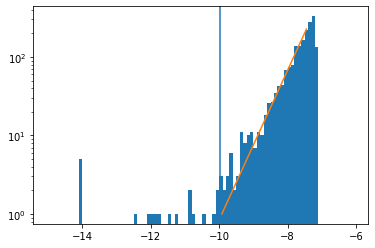

In [162]:
bins = np.arange(-15, -6, 0.1)
ns, _, _ = plt.hist(predict_outlier, bins=bins, log=True)
start_index, end_index = 60, 75
m, b = np.polyfit(bins[start_index:end_index], np.log(ns[start_index:end_index]), 1)

outlier_cutoff = -b/m

plt.plot([outlier_cutoff+0.05, bins[end_index]+0.05], [np.exp(m*outlier_cutoff+b), np.exp(m*bins[end_index]+b)])
print(m, b)
plt.axvline(outlier_cutoff)

is_outlier = is_twin | (predict_outlier<outlier_cutoff)

print(np.sum(is_outlier))

plt.show()

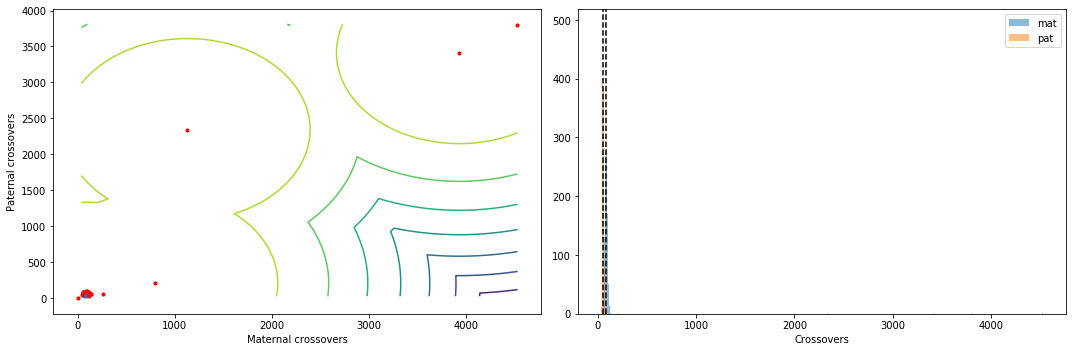

In [163]:
# gaussian
#mean = np.mean(np.hstack((mat_crossovers[:, np.newaxis], pat_crossovers[:, np.newaxis])), axis=0)
#cov = np.cov(np.hstack((mat_crossovers[:, np.newaxis], pat_crossovers[:, np.newaxis])), rowvar=0)

#x, y = np.mgrid[40:150, 40:100]
#pos = np.dstack((x, y))
#rv = stats.multivariate_normal(mean, cov)
#plt.contour(x, y, rv.pdf(pos))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))
plt.scatter(mat_crossovers, pat_crossovers, marker='.', alpha=0.25)
plt.scatter(mat_crossovers[is_outlier], pat_crossovers[is_outlier], marker='.', color='red')
plt.xlabel('Maternal crossovers')
plt.ylabel('Paternal crossovers')

plt.subplot(1, 2, 2)
plt.hist(mat_crossovers, alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), label='mat')
plt.hist(pat_crossovers, alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), label='pat')
plt.axvline(42*2, color='black', linestyle='--')
plt.axvline(28*2, color='black', linestyle='--')
plt.xlabel('Crossovers')
plt.legend()

plt.tight_layout()
plt.show()

In [164]:
x_min, x_max = np.round(np.min(mat_crossovers[~is_outlier]), -1)-10, np.round(np.max(mat_crossovers[~is_outlier]), -1)+10
y_min, y_max = np.round(np.min(pat_crossovers[~is_outlier]), -1)-10, np.round(np.max(pat_crossovers[~is_outlier]), -1)+10

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((mat_crossovers[~is_outlier, np.newaxis],
                                                                    pat_crossovers[~is_outlier, np.newaxis]))) 
xintervals = np.arange(x_min, x_max)
yintervals = np.arange(y_min, y_max)
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))


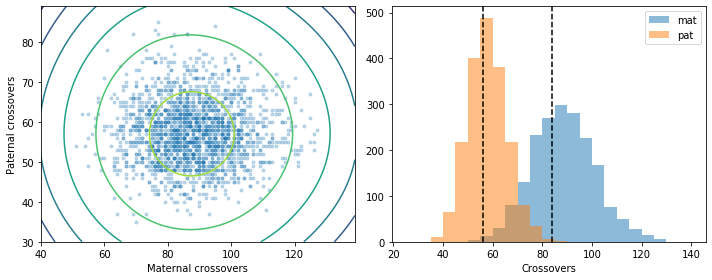

In [165]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))
plt.scatter(mat_crossovers[~is_outlier], pat_crossovers[~is_outlier], marker='.', alpha=0.25)
plt.xlabel('Maternal crossovers')
plt.ylabel('Paternal crossovers')

plt.subplot(1, 2, 2)
plt.hist(mat_crossovers[~is_outlier], alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), label='mat')
plt.hist(pat_crossovers[~is_outlier], alpha=0.5, bins=np.arange(min(x_min, y_min)-5, max(x_max, y_max)+5, 5), label='pat')
plt.axvline(42*2, color='black', linestyle='--')
plt.axvline(28*2, color='black', linestyle='--')
plt.xlabel('Crossovers')
plt.legend()

plt.tight_layout()
plt.show()

In [166]:
x_min, x_max = np.round(np.min(mat_gcs[~is_outlier]), -1)-10, np.round(np.max(mat_gcs[~is_outlier]), -1)+10
y_min, y_max = np.round(np.min(pat_gcs[~is_outlier]), -1)-10, np.round(np.max(pat_gcs[~is_outlier]), -1)+10

# KDE
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.hstack((mat_gcs[~is_outlier, np.newaxis],
                                                                    pat_gcs[~is_outlier, np.newaxis]))) 
xintervals = np.arange(x_min, x_max)
yintervals = np.arange(y_min, y_max)
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))


In [167]:
x_min, x_max = 0.2, 0.8
y_min, y_max = 0.2, 0.8

kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.hstack((mat_ibd[~is_outlier, np.newaxis],
                                                                    pat_ibd[~is_outlier, np.newaxis]))) 
xintervals = np.arange(x_min, x_max, 0.01)
yintervals = np.arange(y_min, y_max, 0.01)
gridx, gridy = np.meshgrid(xintervals, yintervals)

predict = kde.score_samples(np.hstack((gridx.flatten()[:, np.newaxis], gridy.flatten()[:, np.newaxis])))


0.5038021415387951 0.0021842422504633856 57.2280844642948
0.5044359651603081 0.004412696559670774 28.327350025021005


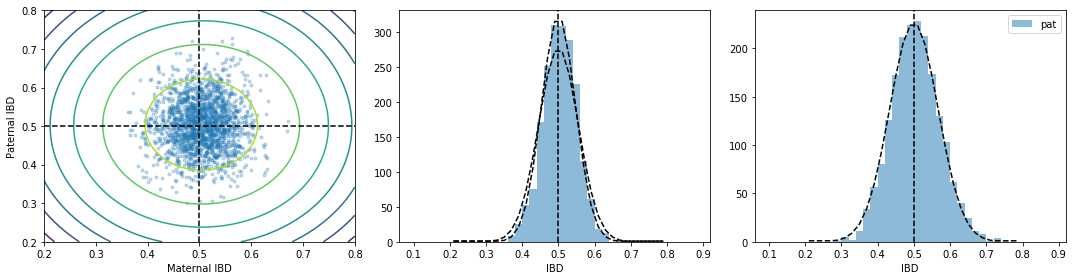

In [168]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))
plt.scatter(mat_ibd[~is_outlier], pat_ibd[~is_outlier], marker='.', alpha=0.25)
plt.xlabel('Maternal IBD')
plt.ylabel('Paternal IBD')
plt.axvline(0.5, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')

plt.subplot(1, 3, 2)
m, s = np.mean(mat_ibd[~is_outlier]), np.std(mat_ibd[~is_outlier])
print(m, s**2, 0.125/(s**2))
plt.hist(mat_ibd, alpha=0.5, bins=np.arange(min(x_min, y_min)-0.1, max(x_max, y_max)+0.1, 0.02), label='mat')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlabel('IBD')
#plt.legend()

bins = np.arange(0.2, 0.8, 0.02)

p = 0.5
n = 2*42
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1]+0.01, np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')


p = 0.5
n = 2*57
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1]+0.01, np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')

plt.subplot(1, 3, 3)
m, s = np.mean(pat_ibd[~is_outlier]), np.std(pat_ibd[~is_outlier])
print(m, s**2, 0.125/(s**2))
plt.hist(pat_ibd, alpha=0.5, bins=np.arange(min(x_min, y_min)-0.1, max(x_max, y_max)+0.1, 0.02), label='pat')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlabel('IBD')
#plt.legend()

p = 0.5
n = 2*28
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1]+0.01, np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

In [169]:
print(0.004340147844017723/0.0021786529408382173)
print(0.004412696559670774/0.0021842422504633856)
print(0.004365211270718152/0.0021944068142181073)
print(0.004436642163302724/0.0021527648755105358)

1.9921244741018225
2.0202413714571374
1.989244310779051
2.0609041952389524


In [170]:
print(np.median(mat_crossovers[~is_outlier])-22)
print(np.median(pat_crossovers[~is_outlier])-22)

66.0
35.0


In [171]:
print(np.sort(pat_crossovers[~is_outlier]))
print(np.sum(pat_crossovers[~is_outlier]<44)/np.sum(~is_outlier))
print(np.sum(pat_crossovers[~is_outlier]<44))

print(np.sum(mat_crossovers[~is_outlier]<44)/np.sum(~is_outlier))


[35 37 37 ... 83 84 85]
0.027821522309711286
53
0.0


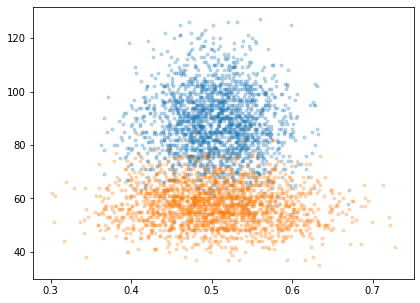

In [172]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(mat_ibd[~is_outlier], mat_crossovers[~is_outlier], alpha=0.25, marker='.')

#plt.subplot(1, 2, 2)
plt.scatter(pat_ibd[~is_outlier], pat_crossovers[~is_outlier], alpha=0.25, marker='.')

plt.show()

In [250]:
# Define and solve the CVXPY problem.
a = cp.Variable()
b = cp.Variable()

r = a*mat_crossovers[~is_outlier] + b
l = cp.sum(cp.log(cp.sqrt(2*r/math.pi))) - \
           ((2*r) @ ((mat_ibd[~is_outlier]-0.5)**2))
prob = cp.Problem(cp.Maximize(l))
prob.solve(solver='ECOS')

print(a.value, b.value)

a = cp.Variable()
b = cp.Variable()
r = a*pat_crossovers[~is_outlier] + b
l = cp.sum(cp.log(cp.sqrt(2*r/math.pi))) - \
            ((2*r) @ ((pat_ibd[~is_outlier]-0.5)**2))
prob = cp.Problem(cp.Maximize(l))
prob.solve(solver='ECOS')

print(a.value, b.value)



#a_mat = 1.32, a_pat = 1.00, a_both = 1.14 when b=0
#b_mat = 27, b_pat = 0, b_both = 6.83 when a=1

# a_mat = 1.46, b_mat = -11.63
# a_pat = 0.88, b_pat = 6.49
# a_both = 1.63, b_both = -32.60


1.4564677579081737 -11.627013359664879
0.8837345481512027 6.486745420854591


In [227]:
# Define and solve the CVXPY problem.
a = cp.Variable()
b_mat = cp.Variable()
b_pat = cp.Variable()
l = cp.sum(cp.log(cp.sqrt(2*(a*mat_crossovers[~is_outlier]+b_mat)/math.pi))) - \
           (2*(a*mat_crossovers[~is_outlier]+b_mat) @ ((mat_ibd[~is_outlier]-0.5)**2)) + \
           cp.sum(cp.log(cp.sqrt(2*(a*pat_crossovers[~is_outlier]+b_pat)/math.pi))) - \
           (2*(a*pat_crossovers[~is_outlier]+b_pat) @ ((pat_ibd[~is_outlier]-0.5)**2))

prob = cp.Problem(cp.Maximize(l))
prob.solve(solver='ECOS')

print(a.value, b_mat.value, b_pat.value)



1.1111610097858964 17.55261623455343 -6.094057849507018


In [229]:
# Define and solve the CVXPY problem.
b = cp.Variable()
a_mat = cp.Variable()
a_pat = cp.Variable()
l = cp.sum(cp.log(cp.sqrt(2*(a_mat*mat_crossovers[~is_outlier]+b)/math.pi))) - \
           (2*(a_mat*mat_crossovers[~is_outlier]+b) @ ((mat_ibd[~is_outlier]-0.5)**2)) + \
           cp.sum(cp.log(cp.sqrt(2*(a_pat*pat_crossovers[~is_outlier]+b)/math.pi))) - \
           (2*(a_pat*pat_crossovers[~is_outlier]+b) @ ((pat_ibd[~is_outlier]-0.5)**2))

prob = cp.Problem(cp.Maximize(l))
prob.solve(solver='ECOS')

print(a_mat.value, a_pat.value, b.value)



1.2928417022772036 0.9549701135245557 2.4598007694887696


mat 27.019999999999214
pat 0.039999999999785985


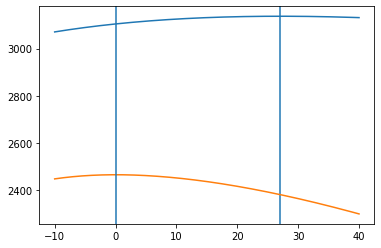

In [245]:
b = np.arange(-10, 40, 0.01)
a = 1

l_mat, l_pat = np.zeros((len(b),)), np.zeros((len(b),))
for i in np.where(~is_outlier)[0]:
    l_mat += np.log(np.sqrt(2*(a*mat_crossovers[i]+b)/math.pi))
    l_mat -= 2*(a*mat_crossovers[i]+b)*((mat_ibd[i]-0.5)**2)
    
    l_pat += np.log(np.sqrt(2*(a*pat_crossovers[i]+b)/math.pi))
    l_pat -= 2*(a*pat_crossovers[i]+b)*((pat_ibd[i]-0.5)**2)

    
plt.plot(b, l_mat)
print('mat', b[np.argmax(l_mat)])
plt.axvline(b[np.argmax(l_mat)])
plt.plot(b, l_pat)
print('pat', b[np.argmax(l_pat)])
plt.axvline(b[np.argmax(l_pat)])
plt.show()

mat 1.3210000000000004
pat 0.9990000000000001


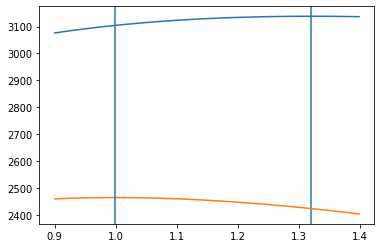

In [243]:
b = 0
a = np.arange(0.9, 1.4, 0.001)

l_mat, l_pat = np.zeros((len(a),)), np.zeros((len(a),))
for i in np.where(~is_outlier)[0]:
    l_mat += np.log(np.sqrt(2*(a*mat_crossovers[i]+b)/math.pi))
    l_mat -= 2*(a*mat_crossovers[i]+b)*((mat_ibd[i]-0.5)**2)
    
    l_pat += np.log(np.sqrt(2*(a*pat_crossovers[i]+b)/math.pi))
    l_pat -= 2*(a*pat_crossovers[i]+b)*((pat_ibd[i]-0.5)**2)

    
plt.plot(a, l_mat)
print('mat', a[np.argmax(l_mat)])
plt.axvline(a[np.argmax(l_mat)])
plt.plot(a, l_pat)
print('pat', a[np.argmax(l_pat)])
plt.axvline(a[np.argmax(l_pat)])
plt.show()

In [242]:
# Define and solve the CVXPY problem.
r = cp.Variable()
l = cp.sum(cp.log(cp.sqrt(2*r/math.pi)) - 2*r*((mat_ibd[~is_outlier]-0.5)**2))
prob = cp.Problem(cp.Maximize(l))
prob.solve(solver='ECOS')

print(r.value, np.median(mat_crossovers[~is_outlier]))

r = cp.Variable()
l = cp.sum(cp.log(cp.sqrt(2*r/math.pi)) - 2*r*((pat_ibd[~is_outlier]-0.5)**2))

prob = cp.Problem(cp.Maximize(l))
prob.solve(solver='ECOS')

print(r.value, np.median(pat_crossovers[~is_outlier]))

113.70306666922373 88.0
56.403133975990706 57.0


In [ ]:
m, s = np.mean(pat_ibd[~is_outlier]), np.std(pat_ibd[~is_outlier])


In [20]:
to_json = []

for (phase_dir, fam, sib1, sib2), mibd, pibd, mcross, pcross, mgc, pgc, isout in zip(sibpairs, 
                                mat_ibd, pat_ibd, 
                                mat_crossovers, pat_crossovers,
                                mat_gcs, pat_gcs, is_outlier):
    if not isout:
        to_json.append({
                'family': fam,
                'sibling1': sib1,
                'sibling2': sib2,
                'phase_dir': phase_dir,
                'maternal_ibd': mibd,
                'paternal_ibd': pibd,
                'maternal_crossovers': mcross,
                'paternal_crossovers': pcross,
                'maternal_gene_conversions': mgc,
                'paternal_gene_conversions': pgc
        })
with open('../%s/sibpairs.json' % dataset_name, 'w+') as f:
    json.dump(to_json, f, cls=NumpyEncoder)